# Fantasy generator

### 0.1: Load imports for all the program cells

In [10]:
import re
import os
import pandas as pd
# Add this to data_preprocessing.py
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader, Subset
# Create train and eval datasets (as done previously if splitting)
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import hashlib
import json
import time
import string
from collections import Counter
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt
import string


## 1: Load the files

#### 1.1: Paths

In [11]:
start_time = time.time()
raw_data_path = "../data/external/dataset_name/"
processed_data_path = "../data/processed/"
tokenized_data_path = "../data/processed/tokenized_dialogues.pkl"
timestamp_path = "./data_update_timestamp.txt"
os.makedirs(processed_data_path, exist_ok=True)

In [12]:
# Function to check if new data exists
def is_new_data(data_path, timestamp_file):
    # Get the latest modification time of files in the dataset
    latest_mod_time = max(os.path.getmtime(os.path.join(root, file))
                            for root, _, files in os.walk(data_path) for file in files)
    # Compare with saved timestamp
    if os.path.exists(timestamp_file):
        with open(timestamp_file, "r") as f:
            last_processed_time = float(f.read())
    else:
        last_processed_time = 0
    # Save new timestamp if new data exists
    if latest_mod_time > last_processed_time:
        with open(timestamp_file, "w") as f:
            f.write(str(latest_mod_time))
        return True
    return False

# Initialize process_data based on whether new data exists
if is_new_data(raw_data_path, timestamp_path):
    print("New data detected. Proceeding with data processing...")
    process_data = True
else:
    print("No new data detected. Skipping data processing...")
    process_data = False


# Example: After processing data
if process_data:
    print(f"Data processing completed in {time.time() - start_time:.2f} seconds.")

No new data detected. Skipping data processing...


In [13]:
# Create processed directory if it doesn't exist
os.makedirs(processed_data_path, exist_ok=True)

# Define function to load different types of data files
def load_data(file_path):
    if file_path.endswith(".txt"):
        with open(file_path, "r", encoding="utf-8") as file:
            return file.readlines()
    elif file_path.endswith(".csv"):
        try:
            return pd.read_csv(file_path, on_bad_lines='skip')
        except pd.errors.ParserError as e:
            print(f"Error reading {file_path}: {e}")
            return None
    elif file_path.endswith(".tsv"):
        try:
            return pd.read_csv(file_path, sep="\t", on_bad_lines='skip')
        except pd.errors.ParserError as e:
            print(f"Error reading {file_path}: {e}")
            return None
    else:
        print(f"Skipping unsupported file format: {file_path}")
        return None



# Clean text function for TXT files
def clean_text(data):
    # Basic cleaning: remove special tokens and whitespace
    cleaned_data = [re.sub(r"__eou__", "", line).strip() for line in data]
    cleaned_data = [re.sub(r"\s+", " ", line) for line in cleaned_data]
    return cleaned_data

# Save function to write cleaned data
def save_data(data, file_path):
    if isinstance(data, list):
        # If data is a list (for TXT files)
        with open(file_path, "w", encoding="utf-8") as file:
            file.write("\n".join(data))
    elif isinstance(data, pd.DataFrame):
        # If data is a DataFrame (for CSV/TSV files)
        data.to_csv(file_path, index=False)
    else:
        print(f"Unsupported data type for saving: {type(data)}")

# Process each file in the dataset directory
for root, dirs, files in os.walk(raw_data_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        print(f"Processing {file_path}")
        
        # Load the data
        data = load_data(file_path)
        
        # Clean and save text files
        if file_path.endswith(".txt") and data is not None:
            cleaned_data = clean_text(data)
            processed_file_path = os.path.join(processed_data_path, f"cleaned_{file_name}")
            save_data(cleaned_data, processed_file_path)
            print(f"Cleaned and saved TXT data to {processed_file_path}")
        
        # Directly save CSV and TSV files (or apply specific cleaning if needed)
        elif (file_path.endswith(".csv") or file_path.endswith(".tsv")) and data is not None:
            processed_file_path = os.path.join(processed_data_path, f"cleaned_{file_name}")
            save_data(data, processed_file_path)
            print(f"Saved CSV/TSV data to {processed_file_path}")


Processing ../data/external/dataset_name/Archieve\Dataset_bibliography.txt
Cleaned and saved TXT data to ../data/processed/cleaned_Dataset_bibliography.txt
Processing ../data/external/dataset_name/Archieve\ijcnlp_dailydialog.zip
Skipping unsupported file format: ../data/external/dataset_name/Archieve\ijcnlp_dailydialog.zip
Processing ../data/external/dataset_name/Archieve\Synthetic-Persona-Chat-main.zip
Skipping unsupported file format: ../data/external/dataset_name/Archieve\Synthetic-Persona-Chat-main.zip
Processing ../data/external/dataset_name/cornell_university\movie_characters_metadata.tsv
Saved CSV/TSV data to ../data/processed/cleaned_movie_characters_metadata.tsv
Processing ../data/external/dataset_name/cornell_university\movie_conversations.tsv
Saved CSV/TSV data to ../data/processed/cleaned_movie_conversations.tsv
Processing ../data/external/dataset_name/cornell_university\movie_lines.tsv
Saved CSV/TSV data to ../data/processed/cleaned_movie_lines.tsv
Processing ../data/exter

## 2. Tokenize Text Data

### 2.1: Load the tokenizer

In [14]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
os.makedirs(os.path.dirname(tokenized_data_path), exist_ok=True)
if process_data:
    print("Tokenizing new data...")
    tokenized_data = tokenize_data(cleaned_dialogues, tokenizer)
    with open(tokenized_data_path, "wb") as f:
        pickle.dump(tokenized_data, f)
    
    # Save tokenized data for future use
    with open(tokenized_data_path, "wb") as f:
        pickle.dump(tokenized_data, f)
    print(f"Tokenized data saved to {tokenized_data_path}")
else:
    try:
        with open(tokenized_data_path, "rb") as f:
            tokenized_data = pickle.load(f)
        print(f"Loaded previously tokenized data from {tokenized_data_path}")
    except FileNotFoundError:
        print(f"Error: Tokenized data file not found at {tokenized_data_path}. Make sure the file exists or reprocess the data.")
        process_data = True

Loaded previously tokenized data from ../data/processed/tokenized_dialogues.pkl


### 2.2: Set the padding token to be the same as the end-of-sequence token

In [15]:
tokenizer.pad_token = tokenizer.eos_token

### 2.3: Tokenize data

In [16]:
def tokenize_data(data, tokenizer):
    return [tokenizer(line, return_tensors="pt", padding="max_length", truncation=True) for line in data]

### 2.4: Perform Tokenization

In [17]:
# Define paths
raw_data_path = "../data/external/dataset_name/ijcnlp_dailydialog/dialogues_text.txt"
processed_data_path = "../data/processed/cleaned_dialogues_text.txt"
tokenized_data_path = "../data/processed/tokenized_dialogues.pkl"

# Function to load raw data
def load_data(file_path):
    if os.path.isfile(file_path):
        with open(file_path, "r", encoding="utf-8") as file:
            return file.readlines()
    else:
        print(f"File not found: {file_path}")
        return None

# Function to clean text data
def clean_text(data):
    # Basic cleaning: remove special tokens and extra whitespace
    cleaned_data = [re.sub(r"__eou__", "", line).strip() for line in data]
    cleaned_data = [re.sub(r"\s+", " ", line) for line in cleaned_data]
    return cleaned_data

# Function to save cleaned data to a file
def save_data(data, file_path):
    with open(file_path, "w", encoding="utf-8") as file:
        file.write("\n".join(data))

# Function to tokenize data
def tokenize_data(data, tokenizer):
    return [
        tokenizer(line, return_tensors="pt", padding="max_length", truncation=True)
        for line in data
    ]

# Load, clean, and save the data
dialogues = load_data(raw_data_path)
if dialogues is None:
    print("Error: Failed to load dialogues. Check the file path or file format.")
else:
    print(f"Loaded {len(dialogues)} lines from {raw_data_path}")

# Clean the data and check the result
cleaned_dialogues = clean_text(dialogues)
if not cleaned_dialogues:
    print("Error: Cleaning process failed or returned an empty result.")
else:
    print(f"Cleaned dialogues: {len(cleaned_dialogues)} lines")

# Save the cleaned data
save_data(cleaned_dialogues, processed_data_path)
print(f"Data cleaned and saved to {processed_data_path}")

# Tokenize the cleaned dialogues
tokenized_data = tokenize_data(cleaned_dialogues, tokenizer)
print("Data tokenized successfully")

# Save the tokenized data as a pickle file for later use
import pickle

with open(tokenized_data_path, "wb") as f:
    pickle.dump(tokenized_data, f)
print(f"Tokenized data saved to {tokenized_data_path}")

# Optional: Print sample of tokenized data
print(f"Sample tokenized data: {tokenized_data[:5]}")

Loaded 13118 lines from ../data/external/dataset_name/ijcnlp_dailydialog/dialogues_text.txt
Cleaned dialogues: 13118 lines
Data cleaned and saved to ../data/processed/cleaned_dialogues_text.txt
Data tokenized successfully
Tokenized data saved to ../data/processed/tokenized_dialogues.pkl
Sample tokenized data: [{'input_ids': tensor([[  464,  9592,   336,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}, {'input_ids': tensor([[ 2396, 11740,   837,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}, {'input_ids': tensor([[ 8491,  1243,   991,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}, {'input_ids': tensor([[17353,   345,  2000,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}, {'input_ids': tensor([[ 8491,   345,  1016,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}]


### 2.5: Save tokenized data as a list of token dictionaries

In [18]:
tokenized_data_path = "../data/processed/tokenized_dialogues.pkl"
with open(tokenized_data_path, "wb") as file:
    pickle.dump(tokenized_data, file)

print(f"Tokenized data saved to {tokenized_data_path}")

Tokenized data saved to ../data/processed/tokenized_dialogues.pkl


### 2.6: Save tokenized data as a list of token dictionaries

* In this step, the tokenized data to a file for later use. 
* The tokenized data is stored as a list of dictionaries, where each dictionary contains the input IDs and attention masks for a dialogue. 
* We use the `pickle` module to serialize the tokenized data and save it to a file specified by `tokenized_data_path`.
* This allows to easily load the tokenized data in the future without having to reprocess the raw text data.

In [19]:
class DialogueDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = [item["input_ids"].squeeze() for item in tokenized_data]
        self.attention_masks = [item["attention_mask"].squeeze() for item in tokenized_data]
        
        # Set labels to be the same as input_ids for language modeling
        self.labels = [item["input_ids"].squeeze() for item in tokenized_data]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx]  # Add labels key
        }

### 2.7: Create dataset

In [20]:
dialogue_dataset = DialogueDataset(tokenized_data)

### 2.8: Save the dataset object for later use in training

In [21]:
dataset_path = "../data/processed/dialogue_dataset.pt"
torch.save(dialogue_dataset, dataset_path)
print(f"Structured dataset saved to {dataset_path}")

Structured dataset saved to ../data/processed/dialogue_dataset.pt


## 3.0: Fine-Tune a Pre-trained Model

In [22]:
# Check if the fine-tuned model already exists
fine_tuned_model_path = "./fantasy_model"
if os.path.exists(fine_tuned_model_path):
    print("Fine-tuned model found. Loading the model...")
    try:
        model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_path)
        tokenizer = GPT2Tokenizer.from_pretrained(fine_tuned_model_path)
        print("Fine-tuned model loaded successfully.")
    except Exception as e:
        print(f"Error loading fine-tuned model: {e}. Starting with the base model instead.")
        model_name = "gpt2"
        model = GPT2LMHeadModel.from_pretrained(model_name)
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        tokenizer.pad_token = tokenizer.eos_token

Fine-tuned model found. Loading the model...
Fine-tuned model loaded successfully.


### 3.1: Choose a model

In [23]:
model_name = "gpt2"  # or try 'EleutherAI/gpt-neo-125M' for a larger model
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

### 3.2: Set padding token if it's not set

In [24]:
tokenizer.pad_token = tokenizer.eos_token

### 3.3: Prepare Dataset

In [25]:
# Load the structured dataset
dataset_path = "../data/processed/dialogue_dataset.pt"
dialogue_dataset = torch.load(dataset_path)

C:\Users\Christian\AppData\Local\Temp\ipykernel_21948\1640729464.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dialogue_dataset = torch.load(dataset_path)


#### 3.3.1: Set up a DataLoader for batching during training

In [26]:
train_dataloader = DataLoader(dialogue_dataset, batch_size=2, shuffle=True)

### 3.4: Fine-Tuning Configuration

#### 3.4.1: Load the dataset with labels

In [27]:
formatted_data_path = "../data/processed/dialogue_dataset.pt"
dialogue_dataset = torch.load(formatted_data_path)

train_indices, eval_indices = train_test_split(
    list(range(len(dialogue_dataset))), test_size=0.2, random_state=42
)
train_dataset = Subset(dialogue_dataset, train_indices)
eval_dataset = Subset(dialogue_dataset, eval_indices)

C:\Users\Christian\AppData\Local\Temp\ipykernel_21948\55335935.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dialogue_dataset = torch.load(formatted_data_path)


#### 3.4.2: Set mixed precision training to FP16

In [28]:
# Set to True for mixed-precision training
fp16_enabled = True 

#### 3.4.3: Set Epochs

In [29]:
num_epochs = 2

#### 3.4.4: Model training arguments

In [30]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.1,
    per_device_train_batch_size=16,
    num_train_epochs=num_epochs,
    logging_dir="./logs",
    save_steps=500,
    fp16=fp16_enabled,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

c:\Users\Christian\anaconda3\envs\venv-ml\lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 3.5: Start Fine-Tuning

In [31]:
if os.path.exists(fine_tuned_model_path):
    print("Fine-tuned model already exists. Skipping training...")
else:
    start_time = time.time()
    print("Starting model fine-tuning...")
    trainer.train()
    print(f"Fine-tuning completed in {time.time() - start_time:.2f} seconds.")
    model.save_pretrained(fine_tuned_model_path)
    tokenizer.save_pretrained(fine_tuned_model_path)
    print(f"Fine-tuned model saved to {fine_tuned_model_path}")


Fine-tuned model already exists. Skipping training...


### 3.6: Save the Fined-tuned Model

In [32]:
model.save_pretrained("./fantasy_model")
tokenizer.save_pretrained("./fantasy_model")

('./fantasy_model\\tokenizer_config.json',
 './fantasy_model\\special_tokens_map.json',
 './fantasy_model\\vocab.json',
 './fantasy_model\\merges.txt',
 './fantasy_model\\added_tokens.json')

## 4.0: Generate a Fantasy Paragraph

### 4.1: Load the fine-tuned model and tokenizer

In [49]:
# Define the input parameters for dialogue generation
tone = "serious"  # Options: 'humorous', 'serious', etc.
character_trait = "sarcastic"  # Options: 'sarcastic', 'stoic', etc.
context = "a tense negotiation"

# Combine input into a single prompt for the model
input_prompt = f"The following dialogue takes place in {context}. The NPC's tone is {tone} and their character trait is {character_trait}."

print(f"Input Prompt: {input_prompt}")

Input Prompt: The following dialogue takes place in a tense negotiation. The NPC's tone is serious and their character trait is sarcastic.


In [50]:
model = GPT2LMHeadModel.from_pretrained("./fantasy_model")
tokenizer = GPT2Tokenizer.from_pretrained("./fantasy_model")

### 4.2: Generate Text

#### 4.2.1: Input prompt to guide the model

In [51]:
# Tokenize the input prompt
input_ids = tokenizer.encode(input_prompt, return_tensors="pt")

# Generate dialogue
output = model.generate(
    input_ids,
    max_length=50,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    temperature=0.7,
)

# Decode and print the generated text
# Decode the generated dialogue
generated_dialogue = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"Generated Dialogue:\n{generated_dialogue}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated Dialogue:
The following dialogue takes place in a tense negotiation. The NPC's tone is serious and their character trait is sarcastic.

"I'm sorry, but I'm not sure what you're talking about. I don't know what to do. You


In [36]:
prompt = "In the mystical forest, under a harsh sun, a Monster moves silently among the ancient trees."

#### 4.2.2: Encode the prompt

In [37]:
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

#### 4.2.3: Generate text

In [38]:
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=7500,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    pad_token_id=tokenizer.eos_token_id  # Set pad_token_id to eos_token_id for open-end generation
)

In [48]:
# Update parameters
tone = "serious"  # Change the tone
character_trait = "stoic"  # Change the character trait
context = "Some one died"

# Create a new input prompt
new_input_prompt = f"The following dialogue takes place in {context}. The NPC's tone is {tone} and their character trait is {character_trait}."

# Tokenize the updated input prompt
new_input_ids = tokenizer.encode(new_input_prompt, return_tensors="pt")

# Generate new dialogue
new_output = model.generate(
    new_input_ids,
    max_length=50,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    temperature=0.7,
)

# Decode the new dialogue
new_generated_dialogue = tokenizer.decode(new_output[0], skip_special_tokens=True)
print(f"New Generated Dialogue:\n{new_generated_dialogue}")


c:\Users\Christian\anaconda3\envs\venv-ml\lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning:

`do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


New Generated Dialogue:
The following dialogue takes place in Some one died. The NPC's tone is serious and their character trait is stoic.

"I'm sorry, but I'm not sure what to do. I don't know what I should do, and


#### 4.2.4: Decode the output

In [40]:
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

## 5.0: Save the output

### 5.1: Create folder output variable

In [41]:
output_folder = "../results/generated_paragraphs"

### 5.2: Create the folder if it doesn't exist

In [42]:
os.makedirs(output_folder, exist_ok=True)

### 5.3: Define the file path for the output text file

In [43]:
file_path = os.path.join(output_folder, "generated_paragraph.txt")

### 5.4: Write the generated text to a .txt file

In [44]:
# Save metadata after successful processing and training
metadata = {
    "last_data_update": time.time(),
    "model_path": fine_tuned_model_path
}
try:
    with open("metadata.json", "w") as f:
        json.dump(metadata, f)  # Save the metadata dictionary
    print("Metadata saved successfully.")
except Exception as e:
    print(f"Error saving metadata: {e}")


Metadata saved successfully.


In [45]:
with open("metadata.json", "w") as f:
    json.dump(metadata, f)
    print("Metadata saved successfully.")

Metadata saved successfully.


## Step 6: Visualization

In [46]:
# Example data for training and validation loss
epochs = [1, 2, 3, 4]  # Example epoch numbers
training_loss = [0.8, 0.6, 0.4, 0.3]  # Example training losses
validation_loss = [0.9, 0.7, 0.5, 0.4]  # Example validation losses

# Plotly: Training and Validation Loss
fig = px.line(
    x=epochs,
    y=[training_loss, validation_loss],
    labels={'x': "Epochs", 'y': "Loss"},
    title="Training and Validation Loss Over Epochs"
)
fig.add_scatter(x=epochs, y=training_loss, mode="lines+markers", name="Training Loss")
fig.add_scatter(x=epochs, y=validation_loss, mode="lines+markers", name="Validation Loss")
fig.show()

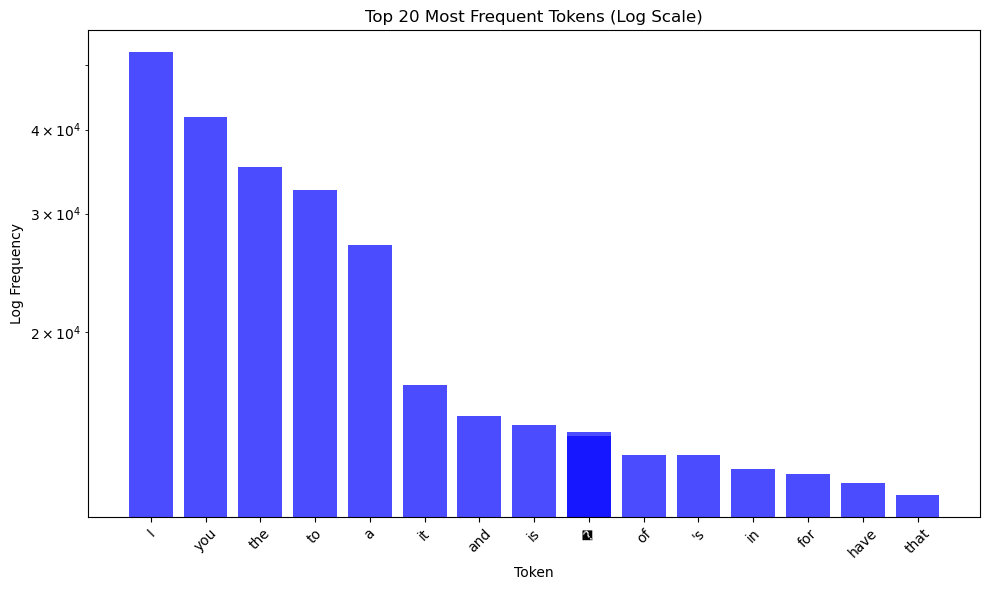

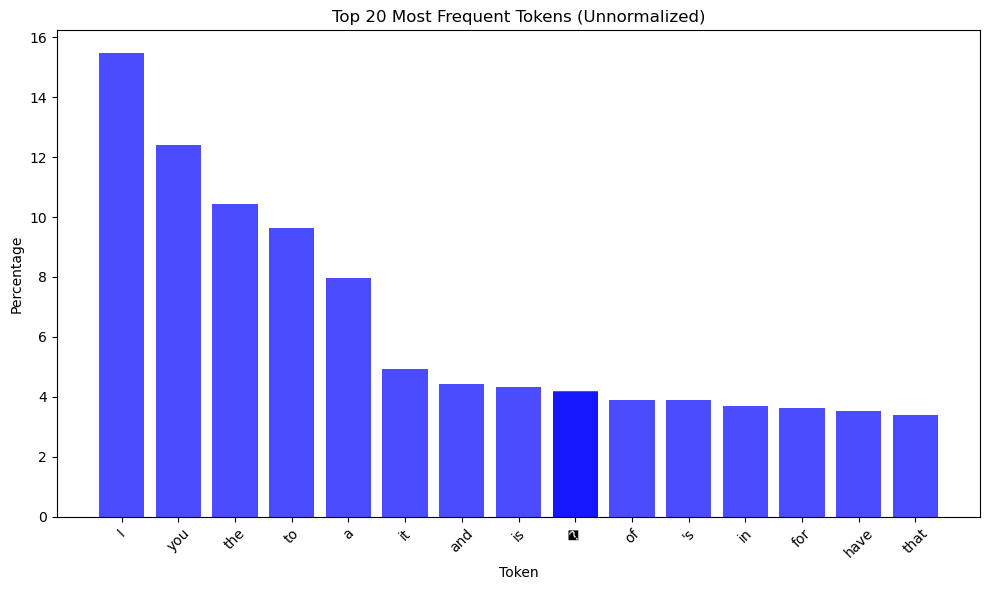

In [47]:
# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Assume `dialogue_dataset` is your dataset and contains tokenized input_ids
# Flatten all tokenized input_ids into one list
all_tokens = []
for data in dialogue_dataset:
    all_tokens.extend(data["input_ids"].tolist())

# Count the frequency of each token
token_counts = Counter(all_tokens)
# Define punctuation set and unwanted tokens
punctuation_set = set(string.punctuation)
unwanted_tokens = ["|<endoftext>|", "<|endoftext|>", " ", "▁"]  # Include end-of-text, space, and similar tokens

# Filter out punctuation, unwanted tokens, and empty tokens
filtered_tokens = []
filtered_counts = []
for token, count in token_counts.most_common(20):  # Get top 20 tokens
    token_text = tokenizer.decode([token]).strip()
    if (
        token_text not in punctuation_set
        and token_text not in unwanted_tokens
        and token_text
    ):
        filtered_tokens.append(token)
        filtered_counts.append(count)

# Map filtered token IDs to text
filtered_token_texts = [tokenizer.decode([token]).strip() for token in filtered_tokens]

# Plot the bar chart with log scale for filtered tokens
plt.figure(figsize=(10, 6))
plt.bar(filtered_token_texts, filtered_counts, color="blue", alpha=0.7)
plt.yscale("log")  # Use log scale for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Top 20 Most Frequent Tokens (Log Scale)")
plt.xlabel("Token")
plt.ylabel("Log Frequency")
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Normalize counts to percentages
total_count = sum(filtered_counts)
normalized_counts = [count / total_count * 100 for count in filtered_counts]

# Plot normalized percentages
plt.figure(figsize=(10, 6))
plt.bar(filtered_token_texts, normalized_counts, color="blue", alpha=0.7)
plt.title("Top 20 Most Frequent Tokens (Unnormalized)")
plt.xlabel("Token")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
